In [54]:
import os
import torch
import pandas as pd
import PIL
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, img_path, target_path, class2idx, transforms = None):
        """
        Inputs
            root: str
                Path to the data folder.
            transforms: Compose or list
                Torchvision image transformations.
        """
        self.transforms = transforms
        self.files = os.listdir(img_path)
        self.df = pd.read_csv(target_path)
        self.df['label'] = self.df['label'].map(class2idx)
        
        self.imgs = []
        self.targets = []
        for i in range(len(self.files)):
            self.imgs.append(PIL.Image.open(os.path.join(img_path, self.files[i])).convert("RGB"))
        for i in range(len(self.files)):
            self.targets.append(self.df[self.df['image'] == self.files[i]])
        
    def __getitem__(self, i):
        target = {}
        target['boxes'] = torch.tensor(self.targets[i][['xmin', 'ymin', 'xmax', 'ymax']].values, dtype = torch.float32)
#         print(target['boxes'].shape, 'each images baxes')
        target['labels'] = torch.tensor(self.targets[i][['label']].values).reshape(-1)
#         img = torch.tensor(self.imgs[i]).permute(0, 3, 1, 2).float() / 255.0
        img = self.imgs[i]
        # Apply any transforms to the data if required.

        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target
    def __len__(self):
        return len(self.files)

import torchvision.transforms.functional as F
import torchvision.transforms.transforms as T
class Compose:
    """
    Composes several torchvision image transforms 
    as a sequence of transformations.
    Inputs
        transforms: list
            List of torchvision image transformations.
    Returns
        image: tensor
        target: dict
    """
    def __init__(self, transforms = []):
        self.transforms = transforms
    # __call__ sequentially performs the image transformations on
    # the input image, and returns the augmented image.
    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target
class ToTensor(torch.nn.Module):
    def forward(self, image, target = None):
        image = F.pil_to_tensor(image)
        image = F.convert_image_dtype(image)
        return image, target
class RandomHorizontalFlip(T.RandomHorizontalFlip):
    """
    Randomly flips an image horizontally.
    Inputs
        image: tensor
        target: dict
    Returns
        image: tensor
        target: dict
    """
    def forward(self, image, target = None):
        if torch.rand(1) < self.p:
            image = F.hflip(image)
#             image = image.flip(-1)
            if target is not None:
                width, _ = F.get_image_size(image)
#                 target['boxes'].clone()
                target["boxes"][:, [0, 2]] = width - target["boxes"][:, [2, 0]]
            
        
        if torch.rand(1) < self.p:
            image = F.vflip(image)
            if target is not None:
                _, h = F.get_image_size(image)
                target["boxes"][:, [1, 3]] = h - target["boxes"][:, [3, 1]]

        return image, target
def get_transform(train):
    transforms = []
    # ToTensor is applied to all images.
    transforms.append(ToTensor())
    # The following transforms are applied only to the train set.
    if train == True:
        transforms.append(RandomHorizontalFlip(0.5))
        # Other transforms can be added here later on.
    return Compose(transforms)
    

class2idx = {'rbc':1, 'wbc':2}
img_path = 'DataSets/archive/images/'
target_path = 'DataSets/archive/annotations.csv'

In [55]:
# class2idx = {'rbc':1, 'wbc':2}
test_img_path = '/Users/vighneshms/Downloads/Red_cell.Ai/Chula-RBC-12-Dataset-main/Dataset'
# target_path = '/Users/vighneshms/Downloads/Red_cell.Ai/DataSets/archive/annotations.csv'

In [56]:
train_ds = CustomDataset(img_path, target_path, class2idx, get_transform(train = True))
# Validation dataset.
val_ds = CustomDataset(img_path, target_path, class2idx, get_transform(train = False))
# Test dataset.
test_ds = CustomDataset(img_path, target_path, class2idx, get_transform(train = False))
# Randomly shuffle all the data.
indices = torch.randperm(len(train_ds)).tolist()
# We split the entire data into 80/20 train-test splits. We further
# split the train set into 80/20 train-validation splits. 
# Train dataset: 64% of the entire data, or 80% of 80%.
train_ds = torch.utils.data.Subset(train_ds,
           indices[:int(len(indices) * 0.64)])
# Validation dataset: 16% of the entire data, or 20% of 80%.
val_ds = torch.utils.data.Subset(val_ds, 
         indices[int(len(indices) * 0.64):int(len(indices) * 0.8)])
# Test dataset: 20% of the entire data.
test_ds = torch.utils.data.Subset(test_ds, 
          indices[int(len(indices) * 0.8):])

def collate_fn(batch):
    return tuple(zip(*batch))
# Create the DataLoaders from the Datasets. 
train_dl = torch.utils.data.DataLoader(train_ds, 
                                 batch_size = 8, 
                                 shuffle = True, 
                        collate_fn = collate_fn)
val_dl = torch.utils.data.DataLoader(val_ds, 
                             batch_size = 8, 
                            shuffle = False, 
                    collate_fn = collate_fn)
test_dl = torch.utils.data.DataLoader(test_ds, 
                               batch_size = 8, 
                              shuffle = False, 
                      collate_fn = collate_fn)

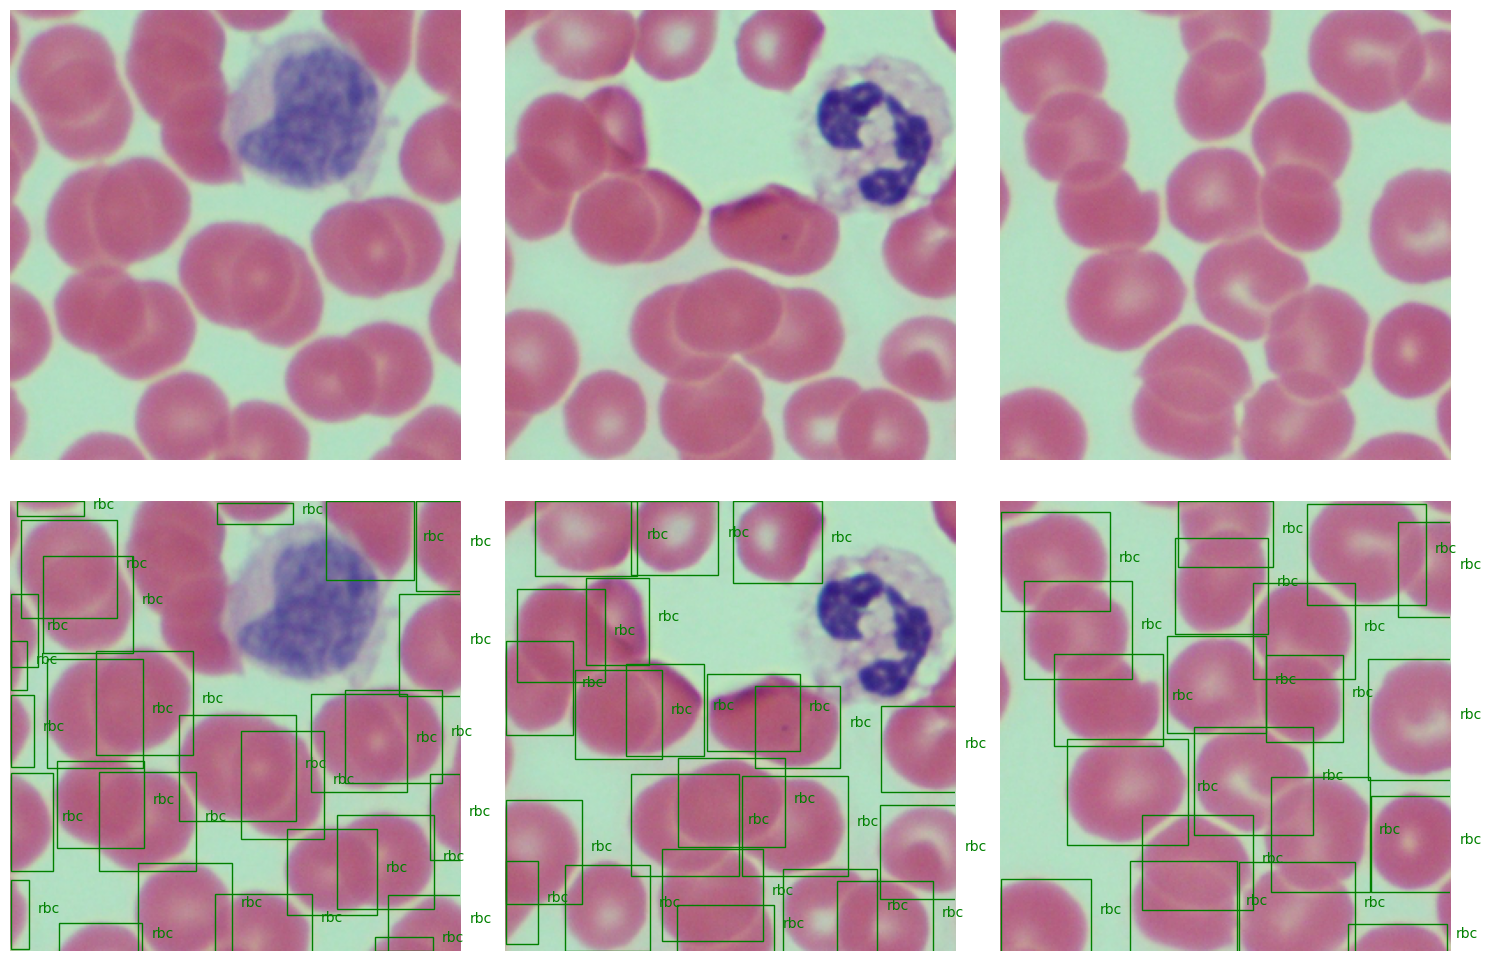

Image 6:
  - Existing RBCs: 28
Image 7:
  - Existing RBCs: 22
Image 0:
  - Existing RBCs: 20


In [57]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch

batch = next(iter(train_dl))
data, target = batch

label_colors = ['r', 'y']  # Colors for labels (RBC, WBC, etc.)
gnd_colors = ['g', 'b']  # Colors for ground truth
image_names = [6, 7, 0]  # Indices of images to visualize

# Create a 2 by 3 subplot grid
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

rbc_counts = {} 

# Loop through each image
for i, image_name in enumerate(image_names):
    # Load the image
    image = data[image_name].permute(1, 2, 0).numpy()

    # Select data for the current image
    selected = target[image_name]
    
    # Extract bounding boxes and labels
    boxes = selected['boxes']
    boxes = torch.vstack((boxes[:, 0], boxes[:, 1], boxes[:, 2]-boxes[:, 0], boxes[:, 3]-boxes[:, 1])).T
    labels = selected['labels']

    rbc_count = 0

    # Plot image without boxes
    ax = axs[0, i]
    ax.imshow(image)
    ax.axis('off')  # Hide axis
    
    # Plot image with boxes
    ax = axs[1, i]
    ax.imshow(image)
    ax.axis('off')  # Hide axis
    
    # Draw bounding boxes and labels
    for box, label in zip(boxes, labels):
        if label.item() == 1:  # Assuming '1' corresponds to RBC
            rbc_count += 1
            x, y, w, h = box
            rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor=gnd_colors[label.item()-1], facecolor='none')
            ax.add_patch(rect)
            ax.text(x + w + 5, y + h // 2, list(class2idx.keys())[label.item()-1], fontsize=10, color=gnd_colors[label.item()-1])

    rbc_counts[f"Image {image_name}"] = rbc_count

plt.tight_layout()
# Show the plot
plt.show()

for image_name, count in rbc_counts.items():
    print(f"{image_name}:")
    print(f"  - Existing RBCs: {count}")


In [77]:
def fastrcnn_loss_modified(class_logits, box_regression, labels, regression_targets):
    # type: (Tensor, Tensor, List[Tensor], List[Tensor]) -> Tuple[Tensor, Tensor]
    """
    Computes the loss for Faster R-CNN.

    Args:
        class_logits (Tensor)
        box_regression (Tensor)
        labels (list[BoxList])
        regression_targets (Tensor)

    Returns:
        classification_loss (Tensor)
        box_loss (Tensor)
    """

    labels = torch.cat(labels, dim=0)
    regression_targets = torch.cat(regression_targets, dim=0)
    w = torch.Tensor([1.0, 1.0, 24.0])
    classification_loss = F.cross_entropy(class_logits, labels, w)
    # get indices that correspond to the regression targets for
    # the corresponding ground truth labels, to be used with
    # advanced indexing
    sampled_pos_inds_subset = torch.where(labels > 0)[0]
    labels_pos = labels[sampled_pos_inds_subset]
    N, num_classes = class_logits.shape
    box_regression = box_regression.reshape(N, box_regression.size(-1) // 4, 4)

    box_loss = F.smooth_l1_loss(
        box_regression[sampled_pos_inds_subset, labels_pos],
        regression_targets[sampled_pos_inds_subset],
        beta=1 / 9,
        reduction="sum",
    )
    box_loss = box_loss / labels.numel()

    return classification_loss, box_loss


In [78]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, fasterrcnn_resnet50_fpn_v2

def get_object_detection_model(num_classes = 3, 
                               feature_extraction = True):
    # Load the pretrained faster r-cnn model.
    model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
    # If True, the pre-trained weights will be frozen.
    if feature_extraction == True:
        for p in model.parameters():
            p.requires_grad = False
    # Replace the original 91 class top layer with a new layer
    # tailored for num_classes.
    in_feats = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_feats,
                                                   num_classes)
    
    model.roi_heads.fastrcnn_loss = fastrcnn_loss_modified
    return model

In [79]:
def unbatch(batch, device):
    """
    Unbatches a batch of data from the Dataloader.
    Inputs
        batch: tuple
            Tuple containing a batch from the Dataloader.
        device: str
            Indicates which device (CPU/GPU) to use.
    Returns
        X: list
            List of images.
        y: list
            List of dictionaries.
    """
    X, y = batch
    X = [x.to(device) for x in X]
    y = [{k: v.to(device) for k, v in t.items()} for t in y]
    return X, y

def train_batch(batch, model, optimizer, device):
    """
    Uses back propagation to train a model.
    Inputs
        batch: tuple
            Tuple containing a batch from the Dataloader.
        model: torch model
        optimizer: torch optimizer
        device: str
            Indicates which device (CPU/GPU) to use.
    Returns
        loss: float
            Sum of the batch losses.
        losses: dict
            Dictionary containing the individual losses.
    """
    model.train()
    X, y = unbatch(batch, device = device)
    optimizer.zero_grad()
    losses = model(X, y)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses

def validate_batch(batch, model, optimizer, device):
    """
    Evaluates a model's loss value using validation data.
    Inputs
        batch: tuple
            Tuple containing a batch from the Dataloader.
        model: torch model
        optimizer: torch optimizer
        device: str
            Indicates which device (CPU/GPU) to use.
    Returns
        loss: float
            Sum of the batch losses.
        losses: dict
            Dictionary containing the individual losses.
    """
    model.train()
    X, y = unbatch(batch, device = device)
    optimizer.zero_grad()
    losses = model(X, y)
    loss = sum(loss for loss in losses.values())
    return loss, losses

In [80]:
import torch_snippets
print(dir(torch_snippets))

['AD', 'ALL_DATE_FORMATS', 'AttrDict', 'AttrDictDeprecated', 'B', 'BB', 'Blank', 'C', 'Config', 'Counter', 'Debug', 'E', 'Excep', 'Glob', 'Image', 'Info', 'L', 'P', 'P0', 'PDF', 'PIL', 'S3Copier', 'Timer', 'Tqdm', 'Trace', 'Warn', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', 'are_dates_equal', 'backup_all_notebooks', 'backup_folders_of_nbs', 'backup_this_notebook', 'batchify', 'bb_utils', 'bbfy', 'bbs2df', 'check_kwargs_not_none', 'choose', 'cli', 'common', 'common_items', 'console', 'crop_from_bb', 'dates', 'dcopy', 'debug_mode', 'decompose', 'decorators', 'defaultdict', 'df2bbs', 'diff', 'dill', 'display_dfs_side_by_side', 'download_s3_file', 'download_s3_folder', 'dumpdill', 'enlarge_bbs', 'excep_mode', 'exists', 'extn', 'find', 'flatten', 'fname', 'fname2', 'folder_structure_to_dict', 'folder_structure_to_json', 'folder_summary', 'format', 'frames', 'get_console', 'get_fs', 'get_logger_level', '

In [81]:
class Report:
    def __init__(self, n_epochs):
        self.n_epochs = n_epochs
        self.records = []

    def record(self, pos, trn_loss=None, val_loss=None, end="\n"):
        record = {'epoch': pos}
        if trn_loss is not None:
            record['train_loss'] = trn_loss
        if val_loss is not None:
            record['val_loss'] = val_loss
        self.records.append(record)
        self._print_record(record, end=end)

    def _print_record(self, record, end="\n"):
        log_message = f"Epoch: {record['epoch']:.2f}"
        if 'train_loss' in record:
            log_message += f" | Train Loss: {record['train_loss']:.4f}"
        if 'val_loss' in record:
            log_message += f" | Val Loss: {record['val_loss']:.4f}"
        print(log_message, end=end)

    def report_avgs(self, total_epochs):
        total_train_loss = sum([r['train_loss'] for r in self.records if 'train_loss' in r])
        total_val_loss = sum([r['val_loss'] for r in self.records if 'val_loss' in r])

        print(f"\nAverage Training Loss over {total_epochs} epochs: {total_train_loss/total_epochs:.4f}")
        if total_val_loss > 0:
            print(f"Average Validation Loss over {total_epochs} epochs: {total_val_loss/total_epochs:.4f}")


In [82]:
def train_fasterrcnn(model, 
                 optimizer, 
                  n_epochs, 
              train_loader, 
        test_loader = None, 
                log = None, 
               keys = None, 
            device = "mps"):

    train_losses, val_losses = [], []
    trn_loss = 0
    trn_size = 0
    val_loss = 0
    val_size = 0
    
    if log is None:
        log = Report(n_epochs)
    if keys is None:
        # FasterRCNN loss names.
        keys = ["loss_classifier", 
                   "loss_box_reg", 
                "loss_objectness", 
               "loss_rpn_box_reg"]
    model.to(device)
    for epoch in range(n_epochs):
        N = len(train_loader)
        for ix, batch in enumerate(train_loader):
            loss, losses = train_batch(batch, model, 
                                  optimizer, device)
            # Record the current train loss.
            pos = epoch + (ix + 1) / N
            log.record(pos = pos, trn_loss = loss.item(), 
                       end = "\r")
            trn_loss += loss.item()
            trn_size += len(batch)
        
        if test_loader is not None:
            N = len(test_loader)
            for ix, batch in enumerate(test_loader):
                loss, losses = validate_batch(batch, model, 
                                         optimizer, device)
                
                # Record the current validation loss.
                pos = epoch + (ix + 1) / N
                log.record(pos = pos, val_loss = loss.item(), 
                           end = "\r")
                val_loss += loss.item()
                val_size += len(batch)
                
        train_losses.append(trn_loss/trn_size)
        val_losses.append(val_loss/val_size)
    log.report_avgs(epoch + 1)
    return log, train_losses, val_losses

In [89]:
import time
device = 'cpu'
model = get_object_detection_model(num_classes = 3,   
                        feature_extraction = False)
# Use the stochastic gradient descent optimizer.
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, 
                        lr = 0.005, 
                    momentum = 0.9, 
             weight_decay = 0.0005)
st = time.time()
log, t_loss, v_loss = train_fasterrcnn(model = model, 
               optimizer = optimizer, 
                        n_epochs = 17,
             train_loader = train_dl, 
                test_loader = val_dl,
             log = None, keys = None,
                     device = device)
et = time.time()
print(et - st)

Epoch: 17.00 | Val Loss: 0.357187
Average Training Loss over 17 epochs: 3.8040
Average Validation Loss over 17 epochs: 0.9605
4090.3456058502197


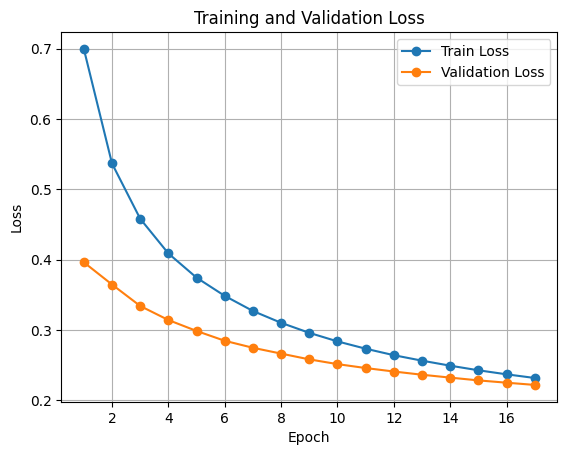

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(t_loss) + 1), t_loss, label='Train Loss', marker='o')
plt.plot(range(1, len(v_loss) + 1), v_loss, label='Validation Loss', marker='o')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [90]:
@torch.no_grad()
def predict_batch(batch, model, device):
    model.to(device)
    model.eval()
    X, ground_truth = unbatch(batch, device = device)
    predictions = model(X)
    return [x.cpu() for x in X], predictions, ground_truth
def predict(model, data_loader, device = "cpu"):
    gnd = []
    images = []
    predictions = []
    for i, batch in enumerate(data_loader):
        X, p, gd = predict_batch(batch, model, device)
        images = images + X
        predictions = predictions + p
        gnd.extend(gd)
    
    return images, predictions, gnd

In [86]:
@torch.no_grad()
def classify_batch(crops, model, device):
    """Classify the cropped regions."""
    model.to(device)
    model.eval()
    transform = transforms.Compose([
        transforms.Resize((64, 64)),  # Match input size of the classification model
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    # Apply transforms to crops
    crops = [transform(crop).unsqueeze(0) for crop in crops]  # Add batch dim
    crops = torch.cat(crops).to(device)  # Concatenate into a single tensor
    outputs = model(crops)
    _, predictions = torch.max(outputs, 1)  # Get predicted labels
    return predictions.cpu().numpy()

@torch.no_grad()
def predict_batch(batch, detection_model, classification_model, device):
    """Predict bounding boxes and classify cropped regions."""
    detection_model.to(device)
    detection_model.eval()
    X, ground_truth = unbatch(batch, device=device)
    detections = detection_model(X)

    results = []
    for img, prediction in zip(X, detections):
        img = img.cpu().permute(1, 2, 0).numpy()  # Convert to NumPy
        boxes, labels, scores = decode_prediction(prediction)

        # Crop detected regions for classification
        crops = []
        for box in boxes:
            xmin, ymin, xmax, ymax = map(int, box)
            cropped_region = Image.fromarray((img * 255).astype('uint8')).crop((xmin, ymin, xmax, ymax))
            crops.append(cropped_region)

        # Classify cropped regions
        if crops:
            classification_results = classify_batch(crops, classification_model, device)
        else:
            classification_results = []

        # Combine results
        results.append({
            "boxes": boxes,
            "labels": labels,
            "scores": scores,
            "classifications": classification_results
        })

    return [x.cpu() for x in X], results, ground_truth

def predict(detection_model, classification_model, data_loader, device="cpu"):
    gnd = []
    images = []
    predictions = []
    for i, batch in enumerate(data_loader):
        X, p, gd = predict_batch(batch, detection_model, classification_model, device)
        images = images + X
        predictions = predictions + p
        gnd.extend(gd)

    return images, predictions, gnd


In [91]:
def decode_prediction(prediction, 
                      score_threshold = 0.8, 
                      nms_iou_threshold = 0.2):
    boxes = prediction["boxes"]
    scores = prediction["scores"]
    labels = prediction["labels"]
    # Remove any low-score predictions.
    if score_threshold is not None:
        want = scores > score_threshold
        boxes = boxes[want]
        scores = scores[want]
        labels = labels[want]
    # Remove any overlapping bounding boxes using NMS.
    if nms_iou_threshold is not None:
        want = torchvision.ops.nms(boxes = boxes, scores = scores, 
                                iou_threshold = nms_iou_threshold)
        boxes = boxes[want]
        scores = scores[want]
        labels = labels[want]
    return (boxes.cpu().numpy(), 
            labels.cpu().numpy(), 
            scores.cpu().numpy())

In [92]:
images, predictions, ground_truth = predict(model, test_dl, device)

In [ ]:
import torch
from collections import Counter

import torch

def reformat_res(predictions, isThereScore):
    res = []
    for i in range(len(predictions)):
        idx = torch.zeros((len(predictions[i]['labels']), 1))
        idx.fill_(i)
        if isThereScore:
            scores = predictions[i]['scores'].reshape(-1, 1)
        else:
            scores = torch.ones(len(predictions[i]['labels']), 1)   
        
        res.append(torch.hstack((idx.cpu(), predictions[i]['labels'].reshape(-1, 1).cpu(),
                                     scores.cpu(), predictions[i]['boxes'].cpu())))
            
    res = torch.cat(res)
    return res
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Calculates intersection over union

    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct Labels of Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)

    Returns:
        tensor: Intersection over union for all examples
    """

    # Slicing idx:idx+1 in order to keep tensor dimensionality
    # Doing ... in indexing if there would be additional dimensions
    # Like for Yolo algorithm which would have (N, S, S, 4) in shape
    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    elif box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # Need clamp(0) in case they do not intersect, then we want intersection to be 0
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="corners", num_classes=2
):
    """
    Calculates mean average precision 

    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones 
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes

    Returns:
        float: mAP value across all classes given a specific IoU threshold 
    """

    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    for c in range(1, num_classes+1):
        
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([int(gt[0].item()) for gt in ground_truths])
        
        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)
#             print(key, val, torch.zeros(val))
#             return
        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
        
        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]
#             print(detection[0], len(ground_truth_img))
            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    detection[3:].clone(),
                    gt[3:].clone(),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
#                 print(amount_bboxes[int(detection[0].item())], detection[0], best_gt_idx)
                if amount_bboxes[int(detection[0].item())][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[int(detection[0].item())][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1
#         print(FP, TP)
#         return
        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))
#         print(type(average_precisions))
#         average_precisions = [float(avg) for avg in average_precisions]
#         print(average_precisions)
    
    arr = torch.stack(average_precisions).sum()
#     print(arr.sum())
    return arr.item() / len(average_precisions)

formated_preds = reformat_res(predictions, True)
formated_gnd = reformat_res(ground_truth, False)
map5 = mean_average_precision(formated_preds,formated_gnd)
print('map@0.5 on test set', map5)

map@0.5 on test set 0.9908840656280518


In [93]:
def calculate_metrics(pred_boxes, true_boxes, iou_threshold=0.5, box_format="corners", num_classes=2):
    """
    Calculates mAP, Precision, Recall, and F1-Score.

    Parameters:
        pred_boxes (list): list of predictions [train_idx, class_pred, score, x1, y1, x2, y2]
        true_boxes (list): list of ground truths [train_idx, class_pred, x1, y1, x2, y2]
        iou_threshold (float): IoU threshold for TP determination
        box_format (str): "midpoint" or "corners"
        num_classes (int): number of classes

    Returns:
        dict: Precision, Recall, F1-Score, and mAP.
    """
    average_precisions = []
    epsilon = 1e-6

    all_tp, all_fp, all_fn = 0, 0, 0  # Aggregate metrics

    for c in range(1, num_classes + 1):
        detections = [d for d in pred_boxes if d[1] == c]
        ground_truths = [g for g in true_boxes if g[1] == c]

        amount_bboxes = Counter([int(gt[0].item()) for gt in ground_truths])
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        for detection_idx, detection in enumerate(detections):
            ground_truth_img = [gt for gt in ground_truths if gt[0] == detection[0]]
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    detection[3:], gt[3:], box_format=box_format
                )
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                if amount_bboxes[int(detection[0].item())][best_gt_idx] == 0:
                    TP[detection_idx] = 1
                    amount_bboxes[int(detection[0].item())][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)

        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))

        average_precisions.append(torch.trapz(precisions, recalls))
        all_tp += TP.sum().item()
        all_fp += FP.sum().item()
        all_fn += total_true_bboxes - TP.sum().item()

    mAP = sum(average_precisions) / len(average_precisions)
    precision = all_tp / (all_tp + all_fp + epsilon)
    recall = all_tp / (all_tp + all_fn + epsilon)
    f1_score = 2 * (precision * recall) / (precision + recall + epsilon)

    return {
        "mAP": mAP,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1_score,
    }


In [ ]:
metrics = calculate_metrics(formated_preds, formated_gnd, iou_threshold=0.5, box_format="corners", num_classes=2)

print(f"mAP@0.5 on test set: {metrics['mAP']:.4f}")
print(f"Precision: {metrics['Precision']:.4f}")
print(f"Recall: {metrics['Recall']:.4f}")
print(f"F1-Score: {metrics['F1-Score']:.4f}")

mAP@0.5 on test set: 0.9909
Precision: 0.8259
Recall: 0.9873
F1-Score: 0.8994


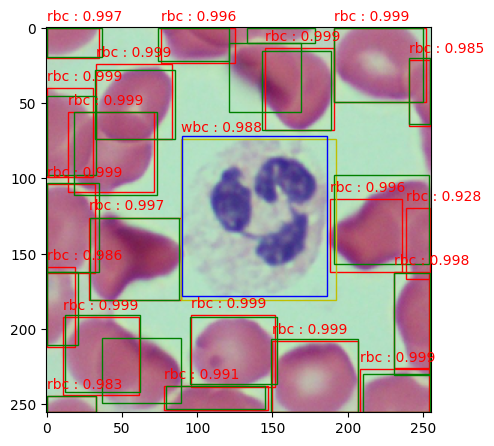

Image 0:
  - Detected RBCs: 20
  - Ground Truth RBCs: 22


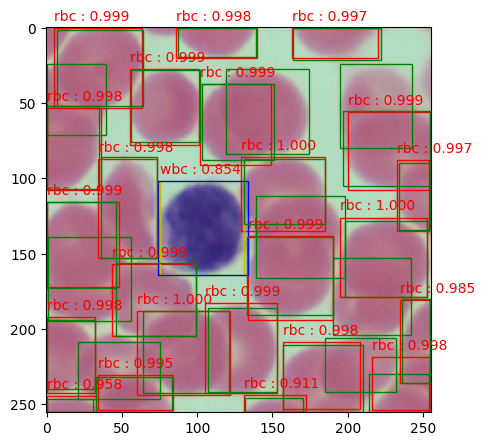

Image 4:
  - Detected RBCs: 23
  - Ground Truth RBCs: 31


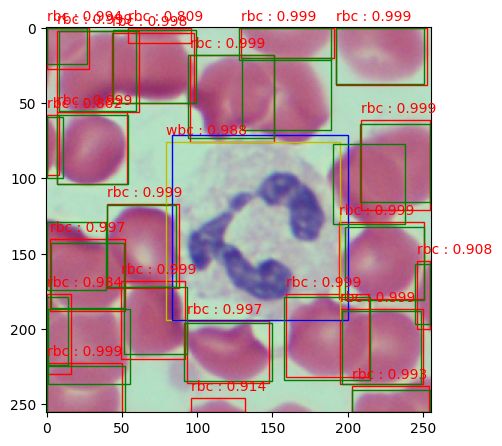

Image 8:
  - Detected RBCs: 22
  - Ground Truth RBCs: 24


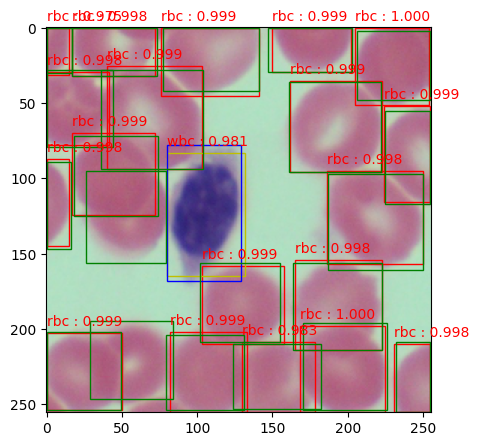

Image 12:
  - Detected RBCs: 19
  - Ground Truth RBCs: 21


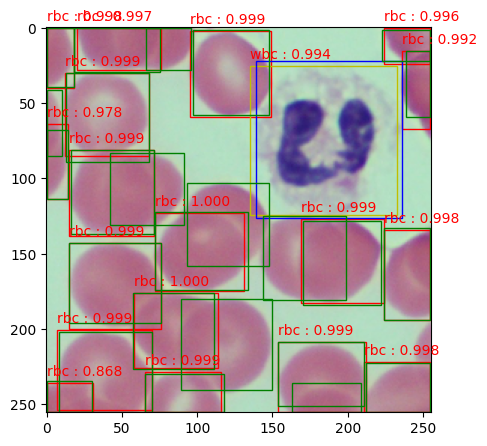

Image 16:
  - Detected RBCs: 18
  - Ground Truth RBCs: 25


In [ ]:
import torchvision
import matplotlib.pyplot as plt
import matplotlib.patches as patches

indxs = [0, 4, 8, 12, 16]

rbc_label_index = list(class2idx.keys()).index("rbc") + 1 

for img_index in indxs:
    boxes, labels, scores = decode_prediction(predictions[img_index])
    gnd_boxes = ground_truth[img_index]['boxes']
    gnd_labels = ground_truth[img_index]['labels']

    rbc_count = 0
    gnd_rbc_count = 0
    
    fig, ax = plt.subplots(figsize = [5, 5])
    ax.imshow(images[img_index].permute(1, 2, 0).numpy())
    for i, b in enumerate(boxes):
        if labels[i].item() == rbc_label_index:  # Check if the label is 'rbc'
            rbc_count += 1 
        rect = patches.Rectangle(b[:2].astype(int),
                                 (b[2] - b[0]).astype(int),
                                 (b[3] - b[1]).astype(int),
                                 linewidth = 1,
                                 edgecolor = label_colors[labels[i].item()-1],
                                 facecolor = "none")
        ax.add_patch(rect)
        ax.text(b[0].astype(int),
                b[1].astype(int) - 5,
                "{} : {:.3f}".format(list(class2idx.keys())[labels[i]-1],
                scores[i]), color = "r")
    for i, b in enumerate(gnd_boxes):
        if gnd_labels[i].item() == rbc_label_index:  # Check if the ground truth label is 'rbc'
            gnd_rbc_count += 1
        rect = patches.Rectangle(b[:2].detach().to(int).cpu(),
                             (b[2] - b[0]).detach().to(int).cpu(),
                             (b[3] - b[1]).detach().to(int).cpu(),
                             linewidth = 1,
                             edgecolor = gnd_colors[gnd_labels[i].item()-1],
                             facecolor = "none")

        ax.add_patch(rect)

    plt.show()

    print(f"Image {img_index}:")
    print(f"  - Detected RBCs: {rbc_count}")
    print(f"  - Ground Truth RBCs: {gnd_rbc_count}")

Using device: mps


/Users/vighneshms/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/vighneshms/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/var/folders/0d/6qdp6tjj2fj9mgn8w3n53sq40000gn/T/ipykernel_2502/4288437010.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release

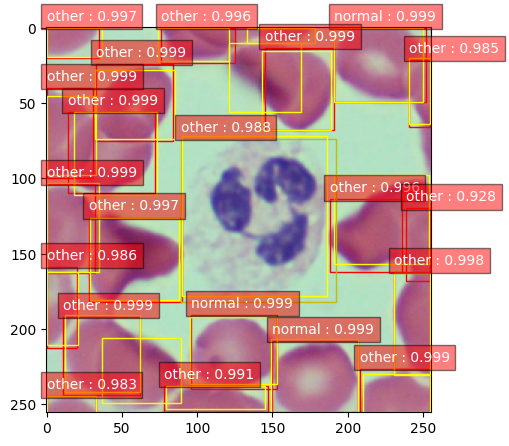

Image 0:
  - Classifications:
  - normal: 3 cells detected
  - macrocyte: 0 cells detected
  - microcyte: 0 cells detected
  - other: 18 cells detected


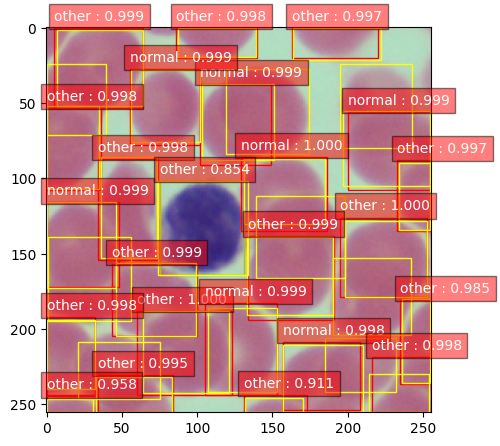

Image 4:
  - Classifications:
  - normal: 7 cells detected
  - macrocyte: 0 cells detected
  - microcyte: 0 cells detected
  - other: 17 cells detected


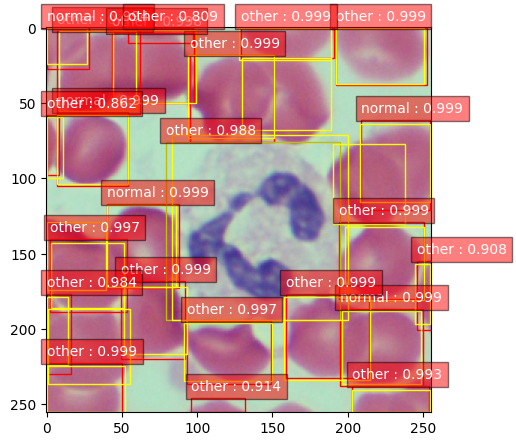

Image 8:
  - Classifications:
  - normal: 5 cells detected
  - macrocyte: 0 cells detected
  - microcyte: 0 cells detected
  - other: 18 cells detected


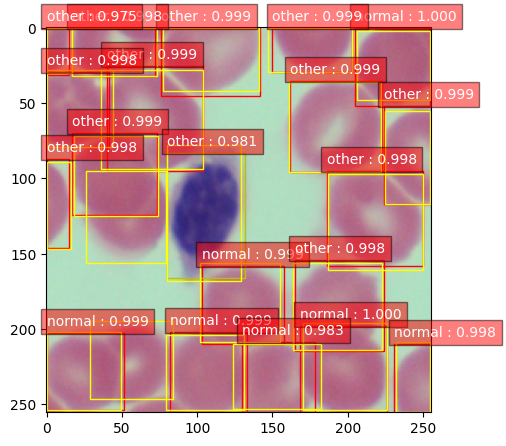

Image 12:
  - Classifications:
  - normal: 7 cells detected
  - macrocyte: 0 cells detected
  - microcyte: 0 cells detected
  - other: 13 cells detected


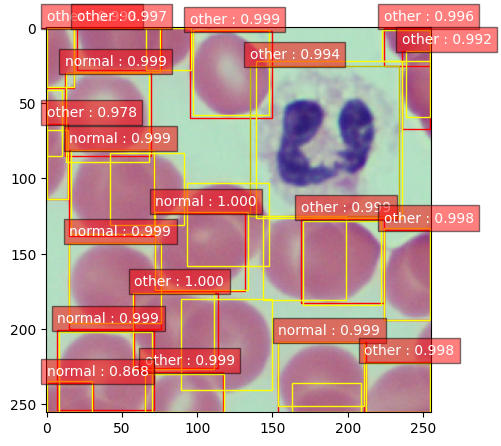

Image 16:
  - Classifications:
  - normal: 7 cells detected
  - macrocyte: 0 cells detected
  - microcyte: 0 cells detected
  - other: 12 cells detected


In [ ]:
import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import torch
from torchvision import models
import numpy as np

# Classification Model Setup (unchanged)
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = models.resnet18(pretrained=False)
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, 4)  # Assuming 4 classes
state_dict = torch.load("/Users/vighneshms/Downloads/Red_cell.Ai/Classification2/rbc_classification_model.pth", map_location=device)
model.load_state_dict(state_dict)
model = model.to(device)
model.eval()

# Transformation pipeline for classification
classification_transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Class names
classes = ["normal", "macrocyte", "microcyte", "other"]

# Integrated Detection and Classification Pipeline
indxs = [0, 4, 8, 12, 16]

for img_index in indxs:
    boxes, labels, scores = decode_prediction(predictions[img_index])
    gnd_boxes = ground_truth[img_index]['boxes']
    gnd_labels = ground_truth[img_index]['labels']

    fig, ax = plt.subplots(figsize=[5, 5])
    ax.imshow(images[img_index].permute(1, 2, 0).numpy())

    classifications = []  # Store classification results

    cell_counts = {class_name: 0 for class_name in classes}

    for i, b in enumerate(boxes):
        # Crop the detected region
        x1, y1, x2, y2 = b.astype(int)
        cropped_img = images[img_index][:, y1:y2, x1:x2].cpu()

        # Skip small or invalid boxes
        if cropped_img.size(1) == 0 or cropped_img.size(2) == 0 or x2 <= x1 or y2 <= y1:
            continue

        # Convert tensor to valid image format
        cropped_img_np = cropped_img.permute(1, 2, 0).numpy()  # C, H, W -> H, W, C
        if cropped_img_np.shape[2] == 1:  # Single-channel image
            cropped_img_np = np.repeat(cropped_img_np, 3, axis=2)  # Convert to RGB
        elif cropped_img_np.shape[2] != 3:  # Invalid channel count
            continue  # Skip invalid images

        # Convert to PIL Image for transforms
        cropped_img_pil = Image.fromarray((cropped_img_np * 255).astype(np.uint8))

        # Apply classification transforms
        cropped_img_tensor = classification_transforms(cropped_img_pil).unsqueeze(0).to(device)

        # Perform classification
        with torch.no_grad():
            output = model(cropped_img_tensor)
            _, predicted_class = torch.max(output, 1)
            predicted_label = classes[predicted_class.item()]
            classifications.append(predicted_label)
            cell_counts[predicted_label] += 1 

        # Draw detection and classification on image
        rect = patches.Rectangle((x1, y1),
                                 x2 - x1,
                                 y2 - y1,
                                 linewidth=1,
                                 edgecolor=label_colors[labels[i].item() - 1],
                                 facecolor="none")
        ax.add_patch(rect)

        # Add classification result as text
        ax.text(x1, y1 - 5,
                f"{predicted_label} : {scores[i]:.3f}",
                color="white",
                bbox=dict(facecolor='red', alpha=0.5))

    # Ground Truth Boxes (Optional)
    for i, b in enumerate(gnd_boxes):
        rect = patches.Rectangle(b[:2].detach().to(int).cpu(),
                                 (b[2] - b[0]).detach().to(int).cpu(),
                                 (b[3] - b[1]).detach().to(int).cpu(),
                                 linewidth=1,
                                 edgecolor="yellow",
                                 facecolor="none")
        ax.add_patch(rect)

    plt.show()

    print(f"Image {img_index}:")
    print(f"  - Classifications:") 
    for cell_type, count in cell_counts.items():
        print(f"  - {cell_type}: {count} cells detected")


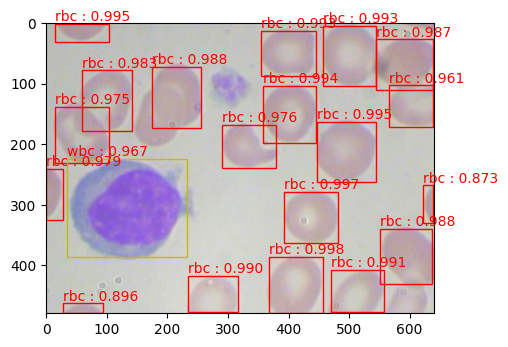

Image 0:
  - Detected RBCs: 19


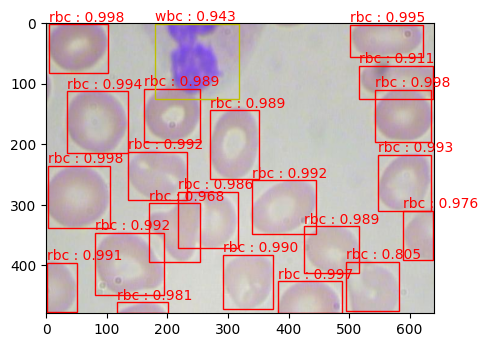

Image 4:
  - Detected RBCs: 21


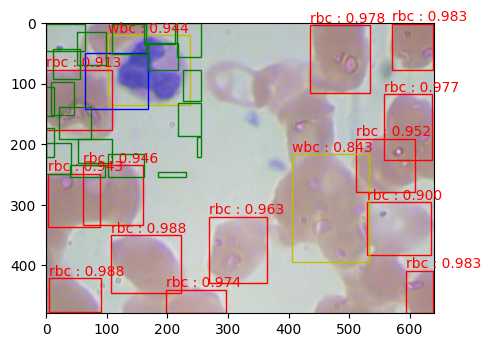

Image 8:
  - Detected RBCs: 13


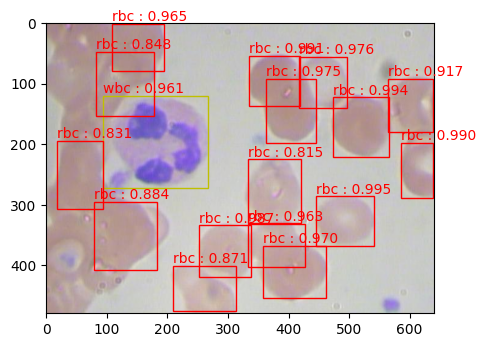

Image 12:
  - Detected RBCs: 16


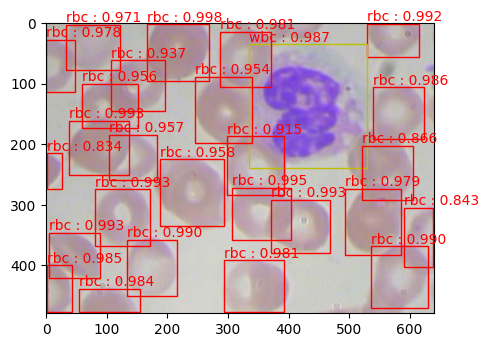

Image 16:
  - Detected RBCs: 26


In [ ]:
import torchvision
import matplotlib.pyplot as plt
import matplotlib.patches as patches

indxs = [0, 4, 8, 12, 16]

rbc_label_index = list(class2idx.keys()).index("rbc") + 1 

for img_index in indxs:
    boxes, labels, scores = decode_prediction(predictions[img_index])
    gnd_boxes = ground_truth[img_index]['boxes']
    gnd_labels = ground_truth[img_index]['labels']

    rbc_count = 0
    
    fig, ax = plt.subplots(figsize = [5, 5])
    ax.imshow(images[img_index].permute(1, 2, 0).numpy())
    for i, b in enumerate(boxes):
        if labels[i].item() == rbc_label_index:  # Check if the label is 'rbc'
            rbc_count += 1 
        rect = patches.Rectangle(b[:2].astype(int),
                                 (b[2] - b[0]).astype(int),
                                 (b[3] - b[1]).astype(int),
                                 linewidth = 1,
                                 edgecolor = label_colors[labels[i].item()-1],
                                 facecolor = "none")
        ax.add_patch(rect)
        ax.text(b[0].astype(int),
                b[1].astype(int) - 5,
                "{} : {:.3f}".format(list(class2idx.keys())[labels[i]-1],
                scores[i]), color = "r")
    for i, b in enumerate(gnd_boxes):
        rect = patches.Rectangle(b[:2].detach().to(int).cpu(),
                             (b[2] - b[0]).detach().to(int).cpu(),
                             (b[3] - b[1]).detach().to(int).cpu(),
                             linewidth = 1,
                             edgecolor = gnd_colors[gnd_labels[i].item()-1],
                             facecolor = "none")

        ax.add_patch(rect)

    plt.show()

    print(f"Image {img_index}:")
    print(f"  - Detected RBCs: {rbc_count}")

In [94]:
from PIL import Image
import torchvision.transforms as T
import torch

# Load image
image_path = "/Users/vighneshms/Downloads/Red_cell.Ai/Chula-RBC-12-Dataset-main/Dataset/1.jpg"
img = Image.open(image_path).convert("RGB")  # Ensure RGB format

# Transform to tensor (C, H, W)
image_transforms = T.Compose([
    T.ToTensor()
])
images = [image_transforms(img)]  # Add to a list to mimic batch-like behavior


Using device: mps


/Users/vighneshms/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/vighneshms/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/var/folders/0d/6qdp6tjj2fj9mgn8w3n53sq40000gn/T/ipykernel_2502/2967788507.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release

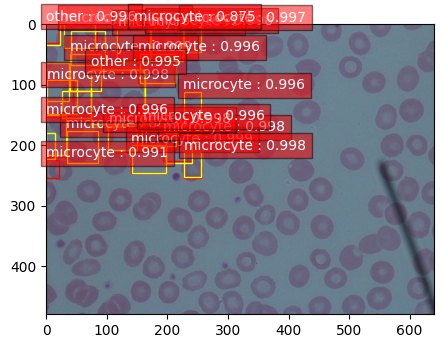

Image 0:
  - Classifications:
  - normal: 0 cells detected
  - macrocyte: 0 cells detected
  - microcyte: 17 cells detected
  - other: 2 cells detected


In [95]:
import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import torch
from torchvision import models
import numpy as np

# Classification Model Setup (unchanged)
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = models.resnet18(pretrained=False)
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, 4)  # Assuming 4 classes
state_dict = torch.load("/Users/vighneshms/Downloads/Red_cell.Ai/Classification2/rbc_classification_model.pth", map_location=device)
model.load_state_dict(state_dict)
model = model.to(device)
model.eval()

# Transformation pipeline for classification
classification_transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Class names
classes = ["normal", "macrocyte", "microcyte", "other"]

# Integrated Detection and Classification Pipeline
indxs = [0]

for img_index in indxs:
    boxes, labels, scores = decode_prediction(predictions[img_index])
    gnd_boxes = ground_truth[img_index]['boxes']
    gnd_labels = ground_truth[img_index]['labels']

    fig, ax = plt.subplots(figsize=[5, 5])
    ax.imshow(images[img_index].permute(1, 2, 0).numpy())

    classifications = []  # Store classification results

    cell_counts = {class_name: 0 for class_name in classes}

    for i, b in enumerate(boxes):
        # Crop the detected region
        x1, y1, x2, y2 = b.astype(int)
        cropped_img = images[img_index][:, y1:y2, x1:x2].cpu()

        # Skip small or invalid boxes
        if cropped_img.size(1) == 0 or cropped_img.size(2) == 0 or x2 <= x1 or y2 <= y1:
            continue

        # Convert tensor to valid image format
        cropped_img_np = cropped_img.permute(1, 2, 0).numpy()  # C, H, W -> H, W, C
        if cropped_img_np.shape[2] == 1:  # Single-channel image
            cropped_img_np = np.repeat(cropped_img_np, 3, axis=2)  # Convert to RGB
        elif cropped_img_np.shape[2] != 3:  # Invalid channel count
            continue  # Skip invalid images

        # Convert to PIL Image for transforms
        cropped_img_pil = Image.fromarray((cropped_img_np * 255).astype(np.uint8))

        # Apply classification transforms
        cropped_img_tensor = classification_transforms(cropped_img_pil).unsqueeze(0).to(device)

        # Perform classification
        with torch.no_grad():
            output = model(cropped_img_tensor)
            _, predicted_class = torch.max(output, 1)
            predicted_label = classes[predicted_class.item()]
            classifications.append(predicted_label)
            cell_counts[predicted_label] += 1 

        # Draw detection and classification on image
        rect = patches.Rectangle((x1, y1),
                                 x2 - x1,
                                 y2 - y1,
                                 linewidth=1,
                                 edgecolor=label_colors[labels[i].item() - 1],
                                 facecolor="none")
        ax.add_patch(rect)

        # Add classification result as text
        ax.text(x1, y1 - 5,
                f"{predicted_label} : {scores[i]:.3f}",
                color="white",
                bbox=dict(facecolor='red', alpha=0.5))

    # Ground Truth Boxes (Optional)
    for i, b in enumerate(gnd_boxes):
        rect = patches.Rectangle(b[:2].detach().to(int).cpu(),
                                 (b[2] - b[0]).detach().to(int).cpu(),
                                 (b[3] - b[1]).detach().to(int).cpu(),
                                 linewidth=1,
                                 edgecolor="yellow",
                                 facecolor="none")
        ax.add_patch(rect)

    plt.show()

    print(f"Image {img_index}:")
    print(f"  - Classifications:") 
    for cell_type, count in cell_counts.items():
        print(f"  - {cell_type}: {count} cells detected")


In [ ]:
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import numpy as np

# Load the new image
image_path = "/Users/vighneshms/Downloads/Red_cell.Ai/Chula-RBC-12-Dataset-main/Dataset/4.jpg"  # Replace with your image path
new_image = Image.open(image_path).convert("RGB")

# Detection Model Setup
detection_transforms = T.Compose([
    T.ToTensor()
])
transformed_image = detection_transforms(new_image).unsqueeze(0).to(device)

# Run Detection
model_detection.eval()  # Ensure detection model is in eval mode
with torch.no_grad():
    detection_output = model_detection(transformed_image)[0]

# Extract Predictions
boxes, labels, scores = decode_prediction(detection_output)

# Prepare for Visualization
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(np.array(new_image))

# Classification
cell_counts = {class_name: 0 for class_name in classes}

for i, box in enumerate(boxes):
    x1, y1, x2, y2 = map(int, box)
    cropped_img = new_image.crop((x1, y1, x2, y2))

    # Apply classification transforms
    cropped_tensor = classification_transforms(cropped_img).unsqueeze(0).to(device)

    # Run Classification
    with torch.no_grad():
        classification_output = model(cropped_tensor)
        _, predicted_class = torch.max(classification_output, 1)
        predicted_label = classes[predicted_class.item()]
        cell_counts[predicted_label] += 1

    # Draw the bounding box and classification label
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor="red", facecolor="none")
    ax.add_patch(rect)
    ax.text(x1, y1 - 5, f"{predicted_label} ({scores[i]:.2f})", color="white", 
            bbox=dict(facecolor='red', alpha=0.5))

# Display Results
plt.show()

# Print Classification Results
print("Classification Results:")
for cell_type, count in cell_counts.items():
    print(f"{cell_type}: {count} cells detected")


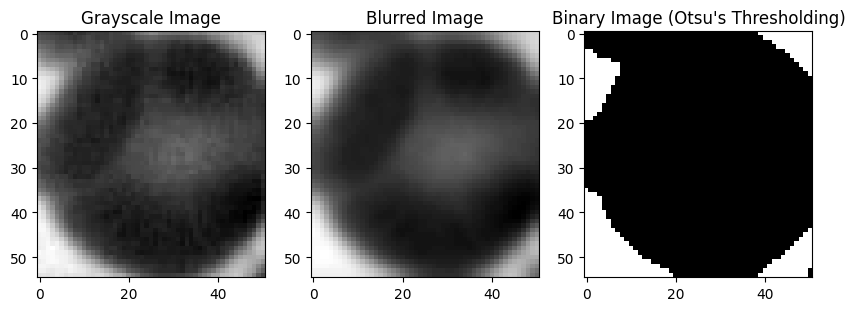

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the image
image = cv2.imread('cropped_rbc_images/rbc_0_0.jpg')

# Step 1: Convert to Grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Step 2: Noise Reduction
# Apply Gaussian Blur
blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

# Step 3: Thresholding
# Apply Otsu's thresholding
_, binary_image = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Optional: Adaptive Thresholding
# adaptive_binary_image = cv2.adaptiveThreshold(blurred_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
#                                              cv2.THRESH_BINARY, 11, 2)

# Display results
plt.figure(figsize=(10, 7))
plt.subplot(1, 3, 1)
plt.title("Grayscale Image")
plt.imshow(gray_image, cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Blurred Image")
plt.imshow(blurred_image, cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Binary Image (Otsu's Thresholding)")
plt.imshow(binary_image, cmap='gray')

plt.show()


In [ ]:
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Define a function to calculate shape features for each contour
def calculate_shape_features(contour):
    features = {}
    
    # Bounding box to calculate Aspect Ratio and Extent
    x, y, w, h = cv2.boundingRect(contour)
    aspect_ratio = float(w) / h
    features['Aspect Ratio'] = aspect_ratio
    
    # Extent
    contour_area = cv2.contourArea(contour)
    bounding_box_area = w * h
    extent = contour_area / bounding_box_area if bounding_box_area > 0 else 0
    features['Extent'] = extent
    
    # Circularity
    perimeter = cv2.arcLength(contour, True)
    if perimeter > 0:
        circularity = 4 * np.pi * (contour_area / (perimeter ** 2))
    else:
        circularity = 0
    features['Circularity'] = circularity
    
    # Convex Hull and Solidity
    hull = cv2.convexHull(contour)
    hull_area = cv2.contourArea(hull)
    if hull_area > 0:
        solidity = contour_area / hull_area
    else:
        solidity = 0
    features['Solidity'] = solidity
    
    return features

# Step 5: Analyze each contour and display shape features
for i, contour in enumerate(contours):
    features = calculate_shape_features(contour)
    print(f"Contour {i + 1} Features:")
    for key, value in features.items():
        print(f"  {key}: {value:.3f}")
    print()

    # Optional: Draw contours on the original image for visualization
    output_image = image.copy()
    cv2.drawContours(output_image, [contour], -1, (0, 255, 0), 2)
    
    # Display each contour
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Contour {i + 1}')
    plt.show()
